In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

%matplotlib inline

import time
from scipy.stats import randint as sp_randint
import seaborn as sns

import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import metrics

from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import mean_squared_error, cohen_kappa_score, make_scorer
from sklearn.metrics import confusion_matrix, accuracy_score, average_precision_score
from sklearn.metrics import precision_recall_curve, SCORERS
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.externals import joblib


import xgboost
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC

from tabulate import tabulate
from datetime import datetime

In [2]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [3]:
def classification_model(model, x_train, x_test, y_train, y_test):
    model_ = model
    model_.fit(x_train, y_train)
    y_hat_test = model_.predict(x_test)
    model_y_score = model_.decision_function(x_test)
#     model_y_score = model_.predict_proba(x_test)[:, 0]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, model_y_score)
    return model_, fpr, tpr, thresholds, y_hat_test

In [4]:
def Print_confusion_matrix():
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    true_negative  = cm[0,0]
    true_positive  = cm[1,1]
    false_negative = cm[1,0]
    false_positive = cm[0,1]
#     tpr = true_positive/(true_positive + false_negative)
#     fpr = false_positive/(false_positive + true_negative)
    total = true_negative + true_positive + false_negative + false_positive
    accuracy = (true_positive + true_negative)/total
    precision = (true_positive)/(true_positive + false_positive)
    recall = (true_positive)/(true_positive + false_negative)
    misclassification_rate = (false_positive + false_negative)/total
    F1 = (2*true_positive)/(2*true_positive + false_positive + false_negative)
    print('accuracy.................%7.4f' % accuracy)
    print('precision................%7.4f' % precision)
    print('recall...................%7.4f' % recall)
    print('F1.......................%7.4f' % F1)
    print('auc......................%7.4f' % auc(fpr, tpr))

In [5]:
def plot_roc_curve(fpr, tpr):
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})

    print('AUC: {}'.format(metrics.auc(fpr, tpr)))
    plt.figure(figsize=(8,6))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    return

In [48]:
#read in merged-weather data
df = pd.read_csv('merged_flight_weather_df.csv')
df.head(3)

,Unnamed: 0,Month,DayofMonth,Origin,Dest,DepTime,DepDelay,ArrTime,ArrDelay,AirTime,...,FlightNumber,SchedDepartTime,hour,datetime,temp,humidity,wind,pressure,description,hours
0,0,1,1,DFW,SFO,2205.0,-3.0,23.0,25.0,223.0,...,AA499,2208.0,22,2017-01-01 22:00:00,65.01,77.0,2.0,1009.0,broken clouds,22
1,1,1,1,DFW,LAS,2212.0,9.0,2316.0,18.0,158.0,...,AA576,2203.0,22,2017-01-01 22:00:00,65.01,77.0,2.0,1009.0,broken clouds,22
2,2,1,1,DFW,RDU,2201.0,96.0,123.0,87.0,128.0,...,AA1606,2105.0,22,2017-01-01 22:00:00,65.01,77.0,2.0,1009.0,broken clouds,22


In [49]:
n_features = len(df.columns)

In [111]:
# Model Parameter Grids Ranges

#Logistic Regression
param_grid1 = {'C': [0.001, 0.01] }

#Random Forest
param_grid2 = {"n_estimators": range(20, 100, 2),
                  "max_depth": range(4, 40, 2),
                  "min_samples_leaf": range(2, 100, 2),
                  "max_features": range(1, n_features+1),
                  "min_samples_split": range(2, 10),
                  "bootstrap": [True],
                  "criterion": ["gini", "entropy"]}

#Gradient Boost
param_grid3 = {'n_estimators': [100],
                  'learning_rate':[0.1],
                  'max_depth': [40]}

#XGBoost
param_grid4 = {'min_child_weight': [1, 5, 10],
                   'learning_rate':[0.001, 0.01,0.1],
                   'gamma': [0.5, 1, 1.5, 2, 5],
                   'subsample': [0.6, 0.8, 1.0],
                   'colsample_bytree': [0.6, 0.8, 1.0],
                   'max_depth': [3, 4, 5]}

#AdaBoost
param_grid5 = {"base_estimator__criterion" : ["gini", "entropy"],
                   'learning_rate':[0.001, 0.01],
                   "base_estimator__splitter" :   ["best", "random"],
                   "n_estimators": [1, 2]}

In [38]:
def grid_search(clf, param_grid):
    global best_model, saved_model
    cv = ShuffleSplit(n_splits = 15, test_size = 0.20, random_state = 2)
    n_iter_search = 70
    estimator = GridSearchCV(clf,
                                   param_grid = param_grid,
                                   scoring = 'roc_auc',
                                   verbose = 0,
                                   cv = cv,
                                   n_jobs = 3)
        
    fit = estimator.fit(x_train, y_train)
    
    best_model = estimator.best_estimator_
    print('\nbest_model:\n', best_model)

#     print('\nFeature Importances:', best_model.feature_importances_)
    
    y_predicted = best_model.predict(x_train)
    probabilities = best_model.predict_proba(x_test)
    y_score = best_model.decision_function(x_test)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score)
    
    plot_roc_curve(fpr, tpr)
    
    c_report = classification_report(y_train, y_predicted)
    print('\nClassification report:\n', c_report)
    return best_model, fit, probabilities, c_report, fpr, tpr, thresholds
    

In [85]:
def grid_search2(clf, param_grid):
    global best_model, saved_model
    cv = ShuffleSplit(n_splits = 15, test_size = 0.20, random_state = 2)
    n_iter_search = 70
    estimator = GridSearchCV(clf,
                                   param_grid = param_grid,
                                   scoring = 'roc_auc',
                                   verbose = 0,
                                   cv = cv,
                                   n_jobs = 3)
        
    fit = estimator.fit(x_resampled, y_resampled)
    
    best_model1 = estimator.best_estimator_
    print('\nbest_model:\n', best_model1)

#     print('\nFeature Importances:', best_model.feature_importances_)
    
    y_predicted = best_model1.predict(x_resampled)
    probabilities = best_model1.predict_proba(x_test)
    y_score = best_model1.decision_function(x_test)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score)
    
    plot_roc_curve(fpr, tpr)
    
    c_report = classification_report(y_resampled, y_predicted)
    print('\nClassification report:\n', c_report)
    return best_model1, fit, probabilities, c_report, fpr, tpr, thresholds
    

In [50]:
df.drop(columns = 'Unnamed: 0', inplace = True)

In [51]:
df1 = df[['Month','DayofMonth', 'hour','Origin', 'Dest', 'SchedDepartTime', 'Distance', 'FlightNumber', 'temp', 'humidity', 'wind', 'pressure', 'ArrDelay', 'DepDelay']]

In [52]:
#Normalize numeric columns
cols_to_norm = ['Distance', 'temp', 'humidity', 'wind', 'pressure', 'ArrDelay']
df_norm = df1[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

In [53]:
df_cat = df1[['Month','DayofMonth', 'hour', 'Origin', 'Dest','SchedDepartTime', 'FlightNumber', 'DepDelay']]

In [54]:
df_cat_norm = pd.concat([df_cat, df_norm], axis = 1)

In [55]:
df_cat_norm['SchedDep'] = df_cat_norm['SchedDepartTime'] // 100

In [56]:
df_cat_norm.drop(columns = 'SchedDepartTime', inplace = True)

In [57]:
df_cat_norm.drop(columns = 'hour', inplace = True)

In [58]:
df_cat_norm[['Month', 'DayofMonth', 'Origin', 'Dest', 'FlightNumber', 'SchedDep']] = df_cat_norm[['Month', 'DayofMonth', 'Origin', 'Dest', 'FlightNumber', 'SchedDep']].astype('category')

In [59]:
df_cat_norm.head(3)

,Month,DayofMonth,Origin,Dest,FlightNumber,DepDelay,Distance,temp,humidity,wind,pressure,ArrDelay,SchedDep
0,1,1,DFW,SFO,AA499,-3.0,0.284174,0.630994,0.757895,0.111111,0.663366,0.075137,22.0
1,1,1,DFW,LAS,AA576,9.0,0.200976,0.630994,0.757895,0.111111,0.663366,0.070861,22.0
2,1,1,DFW,RDU,AA1606,96.0,0.202197,0.630994,0.757895,0.111111,0.663366,0.113012,21.0


In [60]:
df_cat_norm = df_cat_norm[(df_cat_norm['Dest'] == 'DFW') | (df_cat_norm['Dest'] == 'LAX') | (df_cat_norm['Dest'] == 'JFK') | (df_cat_norm['Dest'] == 'MIA') | (df_cat_norm['Dest'] == 'ORD')]

In [61]:
df_cat_norm.shape

(84866, 13)

In [62]:
# target = df_cat_norm['DepDelay']
# df_cat_norm.drop(columns = 'DepDelay', inplace = True)


In [65]:
test = df_cat_norm[(df_cat_norm['Month'] == 9) | (df_cat_norm['Month'] == 10)]

In [66]:
test.head()

,Month,DayofMonth,Origin,Dest,FlightNumber,DepDelay,Distance,temp,humidity,wind,pressure,ArrDelay,SchedDep
545728,9,1,LAX,ORD,UA269,0.0,0.341131,0.723684,0.873684,0.0,0.653465,0.055589,12.0
545735,9,1,LAX,JFK,AA34,-3.0,0.489829,0.723684,0.873684,0.0,0.653465,0.059255,12.0
545738,9,1,LAX,DFW,AA431,-4.0,0.237592,0.723684,0.873684,0.0,0.653465,0.053757,12.0
545750,9,1,LAX,JFK,DL473,-5.0,0.489829,0.723684,0.873684,0.0,0.653465,0.057422,12.0
545757,9,1,LAX,JFK,B6424,-5.0,0.489829,0.723684,0.873684,0.0,0.653465,0.054979,12.0


In [67]:
test.dropna(inplace = True)

/Users/shachiakyaagba/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [68]:
test.head()

,Month,DayofMonth,Origin,Dest,FlightNumber,DepDelay,Distance,temp,humidity,wind,pressure,ArrDelay,SchedDep
545728,9,1,LAX,ORD,UA269,0.0,0.341131,0.723684,0.873684,0.0,0.653465,0.055589,12.0
545735,9,1,LAX,JFK,AA34,-3.0,0.489829,0.723684,0.873684,0.0,0.653465,0.059255,12.0
545738,9,1,LAX,DFW,AA431,-4.0,0.237592,0.723684,0.873684,0.0,0.653465,0.053757,12.0
545750,9,1,LAX,JFK,DL473,-5.0,0.489829,0.723684,0.873684,0.0,0.653465,0.057422,12.0
545757,9,1,LAX,JFK,B6424,-5.0,0.489829,0.723684,0.873684,0.0,0.653465,0.054979,12.0


In [69]:
y_test = test['DepDelay']
x_test = test.drop(columns= 'DepDelay')

In [70]:
train = df_cat_norm[(df_cat_norm['Month'] != 9) & (df_cat_norm['Month'] != 10)]

In [71]:
train.dropna(inplace = True)

/Users/shachiakyaagba/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [72]:
train.head()

,Month,DayofMonth,Origin,Dest,FlightNumber,DepDelay,Distance,temp,humidity,wind,pressure,ArrDelay,SchedDep
7,1,1,DFW,MIA,AA2329,84.0,0.214402,0.630994,0.757895,0.111111,0.663366,0.104459,21.0
18,1,1,DFW,LAX,AA1023,6.0,0.237592,0.630994,0.757895,0.111111,0.663366,0.065363,22.0
19,1,1,DFW,ORD,AA1040,90.0,0.149512,0.630994,0.757895,0.111111,0.663366,0.105070,21.0
21,1,1,DFW,ORD,AA2525,-7.0,0.149512,0.630994,0.757895,0.111111,0.663366,0.041539,22.0
49,1,1,LAX,ORD,AA2576,87.0,0.341131,0.461209,0.800000,0.166667,0.712871,0.095296,17.0


In [73]:
y_train = train['DepDelay']
x_train = train.drop(columns='DepDelay')

In [74]:
def delay(y_train):
    if y_train > 15:
        return 1
    else:
        return 0

In [75]:
def delay2(y_test):
    if y_test > 15:
        return 1
    else:
        return 0

In [76]:
y_train = y_train.apply(delay)

In [77]:
y_test = y_test.apply(delay2)

In [78]:
x_train = pd.get_dummies(x_train, columns = ['Month', 'DayofMonth', 'Origin', 'Dest', 'FlightNumber', 'SchedDep'])

In [79]:
x_test = pd.get_dummies(x_test, columns = ['Month', 'DayofMonth', 'Origin', 'Dest', 'FlightNumber', 'SchedDep'])

## Random Forest Classifier

## Logistic Regression (has decision function)


best_model:
 LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
AUC: 0.7491737138392103


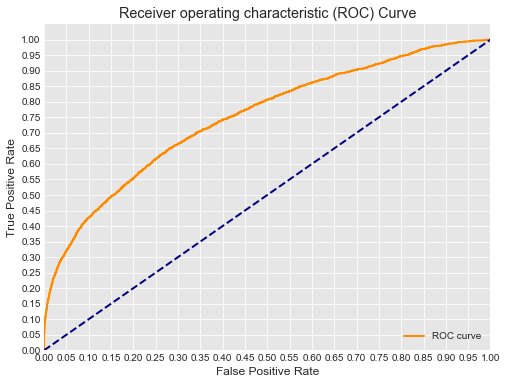


Classification report:
              precision    recall  f1-score   support

          0       0.89      0.68      0.77     52637
          1       0.41      0.72      0.53     16152

avg / total       0.78      0.69      0.72     68789


 Time taken: 0 hours 17 minutes and 30.28 seconds.


In [80]:
start_time = timer(None)
grid_search(LogisticRegression(class_weight = 'balanced'), param_grid1)
timer(start_time)

In [90]:
best_model

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [107]:
file = open('logistic_pickle1','wb')

In [108]:
import pickle

In [109]:
pickle.dump(best_model, file)

In [110]:
file.close()

## SMOTE

In [84]:
from imblearn.over_sampling import SMOTE, ADASYN
print(y_train.value_counts()) #Previous original class distribution
x_resampled, y_resampled = SMOTE(ratio=.4).fit_sample(x_train,y_train)
print(pd.Series(y_resampled).value_counts()) #Preview synthetic sample class distribution

0    52637
1    16152
Name: DepDelay, dtype: int64


/Users/shachiakyaagba/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


0    52637
1    21054
dtype: int64


## GradientBoostClassifier (has decision function)

In [113]:
start_time = timer(None)
grid_search2(GradientBoostingClassifier(), param_grid3)
timer(start_time)

KeyboardInterrupt: 

In [116]:
from sklearn.tree import DecisionTreeClassifier

## AdaBoostClassifier (has decision function) 

In [ ]:
start_time = timer(None)
grid_search2(AdaBoostClassifier(base_estimator= DecisionTreeClassifier()), param_grid5)
timer(start_time)

## SVC (has decision function)